In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import scipy.io
import h5py
%matplotlib inline
from sklearn.preprocessing import normalize
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Dropout, Conv1D,MaxPooling1D, Flatten
import os
import tensorflow as tf
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from numpy import array


In [2]:
Eigen_path = 'drive/My Drive/Colab Notebooks/project/data/stephens-2d-eigenworm-data/stephens-2011-data/EigenWorms.mat'
Footage_path = 'drive/My Drive/Colab Notebooks/project/data/stephens-2d-eigenworm-data/stephens-2011-data/20150814-All-PNAS2011-DataStitched .mat'


In [3]:
class EigenData(object):
    '''Represents the original experiment data.'''

    def __init__(self):
        self._eigenworms = None

    def get_eigenworms(self, eigen_path):
        '''
        Loads the matlab files from the original experiment and parses them
        into expected numpy formats.

        Eigenworms are stored as 100 'angles' at equidistributed coordinates
        down the body.
        '''
        # Load the matlab files into numpy arrays
        eigenworms = scipy.io.loadmat(eigen_path)
        self._eigenworms = eigenworms["EigenWorms"].transpose()
        return self._eigenworms

    def get_footage(self, footage_path):
        '''
        Loads the matlab files from the original experiment and parses them
        into expected numpy formats.

        Footage is stored as coefficients with respect to the eigenworm basis.
        '''
        f = h5py.File(footage_path, 'r')
        footage = {}
        for k, v in f.items():
            if k != 'tr':
                for k2, v2 in v.items():
                    if v2.shape == (5, 33600) or v2.shape == (6, 33600):
                        footage[k2] = np.array(v2)
        return footage

    def reconstruct(self, coefficients):
        '''
        Reconstruct multiple postures from basis coefficients to angles.
        '''
        n_basis_required = coefficients.shape[0]
        print(self._eigenworms[0:n_basis_required, :].transpose().shape,
              coefficients.shape)
        return self._eigenworms[0:n_basis_required, :].transpose() @ \
            coefficients

In [4]:
# if __name__ == "__main__":
data = EigenData()
Eigen_path = 'drive/My Drive/Colab Notebooks/project/data/stephens-2d-eigenworm-data/stephens-2011-data/EigenWorms.mat'
Footage_path = 'drive/My Drive/Colab Notebooks/project/data/stephens-2d-eigenworm-data/stephens-2011-data/20150814-All-PNAS2011-DataStitched .mat'
worm_data = data.get_eigenworms(Eigen_path)

footage = data.get_footage(Footage_path)
for k in footage.keys():
    print(k, footage[k].shape)
    r = data.reconstruct(footage[k])
    print('-->', r.shape)


b (5, 33600)
(100, 5) (5, 33600)
--> (100, 33600)
c (5, 33600)
(100, 5) (5, 33600)
--> (100, 33600)
d (5, 33600)
(100, 5) (5, 33600)
--> (100, 33600)
e (5, 33600)
(100, 5) (5, 33600)
--> (100, 33600)
f (5, 33600)
(100, 5) (5, 33600)
--> (100, 33600)
g (6, 33600)
(100, 6) (6, 33600)
--> (100, 33600)
h (5, 33600)
(100, 5) (5, 33600)
--> (100, 33600)
i (6, 33600)
(100, 6) (6, 33600)
--> (100, 33600)
j (5, 33600)
(100, 5) (5, 33600)
--> (100, 33600)
k (5, 33600)
(100, 5) (5, 33600)
--> (100, 33600)
l (5, 33600)
(100, 5) (5, 33600)
--> (100, 33600)
m (5, 33600)
(100, 5) (5, 33600)
--> (100, 33600)


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

### Worm selection

In [6]:
letter = 'm'
print(letter, footage[letter].shape)
rb = data.reconstruct(footage[letter])
print('-->', rb.shape)

m (5, 33600)
(100, 5) (5, 33600)
--> (100, 33600)


In [7]:

### All the data
raw_data = pd.DataFrame(rb)
raw_data = raw_data.dropna(axis=1)
df = raw_data.T

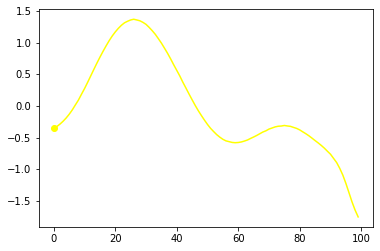

In [8]:
plt.plot(df.T[600],'-o',c='yellow',markevery=[0])


In [9]:
### Normalise the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))

In [10]:
head = df[0]
mid = df[50]

In [11]:
training_head = head[:int(len(head)*0.7)]
testing_head = head[len(training_head):]

In [17]:
df_train_scaler = scaler.fit_transform(training_head.values.reshape(-1, 1))
df_test_scaler = scaler.fit_transform(testing_head.values.reshape(-1, 1))

df_train_scaler.shape, df_test_scaler.shape

((19945, 1), (8549, 1))

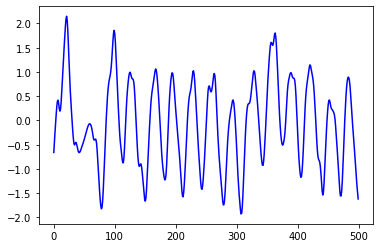

In [23]:
plt.plot(head[:500],c='b')

In [ ]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [ ]:
n_steps = 50
X_train, y_train = split_sequence(df_train_scaler, 50)
X_test, y_test = split_sequence(df_test_scaler,50)


n_features=1
X_train = X_train.reshape((X_train.shape[0],n_steps, n_features))

# y_train = y_train.reshape(y_train.shape[0],1,y_train.shape[1])
X_test = X_test.reshape((X_test.shape[0],  n_steps, n_features))


In [ ]:
X_train.shape, y_train.shape

((19895, 50, 1), (19895, 1))

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Dropout, Conv1D,MaxPooling1D, Flatten,TimeDistributed
import os
import tensorflow as tf
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from keras.layers import Bidirectional


### Bi-direction LSTM

In [ ]:
model = Sequential()  
L0 = CuDNNLSTM(260,input_shape=(50, 1),return_sequences=True)
model.add(Bidirectional(L0))
L1 = CuDNNLSTM(260,return_sequences=True)
model.add(Bidirectional(L1))  
model.add(Dropout(0.2))  
L2 = CuDNNLSTM(260,return_sequences=True)
model.add(L2)
model.add(Dropout(0.2))  
L3 = CuDNNLSTM(260,return_sequences=False)
model.add(L3)
model.add(Dropout(0.2))   
model.add(Dense(1))
A_out = Activation("linear")
model.add(A_out)  
model.compile(loss="mean_squared_error", optimizer="rmsprop")  ######

In [ ]:
import time
start = time.time()
model.fit(X_train,y_train, epochs=100, batch_size=32,verbose=1)

end = time.time()
print(end - start)

Epoch 1/100
622/622 [==============================] - 28s 45ms/step - loss: 0.0078
Epoch 2/100
622/622 [==============================] - 22s 35ms/step - loss: 9.8935e-04
Epoch 3/100
622/622 [==============================] - 22s 35ms/step - loss: 8.1664e-04
Epoch 4/100
622/622 [==============================] - 22s 35ms/step - loss: 7.2098e-04
Epoch 5/100
622/622 [==============================] - 22s 35ms/step - loss: 6.5148e-04
Epoch 6/100
622/622 [==============================] - 22s 35ms/step - loss: 5.8941e-04
Epoch 7/100
622/622 [==============================] - 22s 35ms/step - loss: 5.2862e-04
Epoch 8/100
622/622 [==============================] - 22s 35ms/step - loss: 5.2595e-04
Epoch 9/100
622/622 [==============================] - 22s 35ms/step - loss: 4.9685e-04
Epoch 10/100
622/622 [==============================] - 22s 35ms/step - loss: 6.4026e-04
Epoch 11/100
622/622 [==============================] - 22s 35ms/step - loss: 8.8663e-04
Epoch 12/100
622/622 [============

In [ ]:
bi_lstm = model.predict(X_test)
bi_lstm.shape

(8499, 1)

In [ ]:
bilstm_result = scaler.fit_transform(bi_lstm)

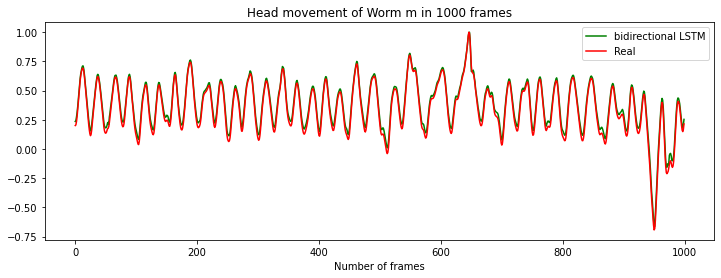

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(bilstm_result[:1000], c='green',label='bidirectional LSTM')
plt.plot(y_test[:1000], label='Real', c='red')
plt.title('Head movement of Worm m in 1000 frames')
plt.xlabel('Number of frames')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

all_euc_lstm_bi = []
all_mse_lstm_bi = []

for i in range(y_test.shape[0]):
  dist3 = np.linalg.norm(y_test[i]- bilstm_result[i])
  all_euc_lstm_bi.append(dist3)
  all_mse_lstm_bi.append(mean_squared_error(y_test[i],bilstm_result[i]))


average_eul_lstm_bi = np.mean(all_euc_lstm_bi)
average_mse_lstm_bi = np.mean(all_mse_lstm_bi)

print(average_eul_lstm_bi)
print(average_mse_lstm_bi)


0.03164630786380809
0.001148445524495932


### LSTM model

In [ ]:
model = Sequential()  
L0 = CuDNNLSTM(260,input_shape=(50, 1),return_sequences=True)
model.add(L0)
L1 = CuDNNLSTM(260,return_sequences=True)
model.add(L1)  
model.add(Dropout(0.2))  
L2 = CuDNNLSTM(260,return_sequences=True)
model.add(L2)  
model.add(Dropout(0.2))  
L3 = CuDNNLSTM(260,return_sequences=False)
model.add(L3)  
model.add(Dropout(0.2))   
model.add(Dense(1))
A_out = Activation("linear")
model.add(A_out)  
model.compile(loss="mean_squared_error", optimizer="rmsprop")  ######
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_4 (CuDNNLSTM)     (None, 50, 260)           273520    
_________________________________________________________________
cu_dnnlstm_5 (CuDNNLSTM)     (None, 50, 260)           542880    
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 260)           0         
_________________________________________________________________
cu_dnnlstm_6 (CuDNNLSTM)     (None, 50, 260)           542880    
_________________________________________________________________
dropout_4 (Dropout)          (None, 50, 260)           0         
_________________________________________________________________
cu_dnnlstm_7 (CuDNNLSTM)     (None, 260)               542880    
_________________________________________________________________
dropout_5 (Dropout)          (None, 260)              

In [ ]:
import time
start = time.time()
model.fit(X_train,y_train, epochs=180, batch_size=32,verbose=1)

end = time.time()
print(end - start)

Epoch 1/180
695/695 [==============================] - 15s 22ms/step - loss: 0.0102
Epoch 2/180
695/695 [==============================] - 15s 22ms/step - loss: 0.0023
Epoch 3/180
695/695 [==============================] - 15s 21ms/step - loss: 0.0017
Epoch 4/180
695/695 [==============================] - 15s 22ms/step - loss: 0.0014
Epoch 5/180
695/695 [==============================] - 15s 22ms/step - loss: 0.0012
Epoch 6/180
695/695 [==============================] - 15s 22ms/step - loss: 0.0011
Epoch 7/180
695/695 [==============================] - 15s 22ms/step - loss: 9.5774e-04
Epoch 8/180
695/695 [==============================] - 15s 22ms/step - loss: 8.9563e-04
Epoch 9/180
695/695 [==============================] - 15s 22ms/step - loss: 8.7327e-04
Epoch 10/180
695/695 [==============================] - 15s 22ms/step - loss: 8.0702e-04
Epoch 11/180
695/695 [==============================] - 15s 22ms/step - loss: 7.6350e-04
Epoch 12/180
695/695 [==============================] 

KeyboardInterrupt: ignored

In [ ]:
test_pred = model.predict(X_test)

In [ ]:
lstm_result = scaler.fit_transform(test_pred)

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(lstm_result[:1500], c='r',label='LSTM')
plt.plot(y_test[:1500], label='Real')
plt.title('Head movement of Worm C in 1500 frames')
plt.xlabel('Number of frames')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


all_euc_lstm = []
all_mse_lstm = []

for i in range(y_test.shape[0]):
  dist = np.linalg.norm(y_test[i]- lstm_result[i])
  all_euc_lstm.append(dist)
  all_mse_lstm.append(mean_squared_error(y_test[i],lstm_result[i]))


average_eul_lstm = np.mean(all_euc_lstm)
average_mse_lstm = np.mean(all_mse_lstm)

print(average_eul_lstm)
print(average_mse_lstm)


In [ ]:
# plt.plot(reduced.T[0],'-o',c='blue',markevery=[0])

# plt.plot(reduced.T[1],'-o',c='red',markevery=[0])

# plt.plot(reduced.T[2],'-o',c='yellow',markevery=[0])

# plt.plot(reduced.T[3],'-o',c='green',markevery=[0])
# plt.show()


# ### Calaulate the projection
# def calculate_projection(given_vector, target_vector):
#   v1_norm = np.sqrt(sum(target_vector**2))     
#   proj_of_u_on_v = (np.dot(given_vector, target_vector)/v1_norm**2)*target_vector

#   return proj_of_u_on_v

# shape_1_projection = np.array([calculate_projection(i,reduced.T[0]) for i in all_shape.T.values])
# shape_2_projection = np.array([calculate_projection(i,reduced.T[1]) for i in all_shape.T.values])
# shape_3_projection = np.array([calculate_projection(i,reduced.T[2]) for i in all_shape.T.values])
# shape_4_projection = np.array([calculate_projection(i,reduced.T[3]) for i in all_shape.T.values])

### CNN model

In [ ]:
model1 = Sequential()
model1.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(50,n_features)))
model1.add(Dropout(0.2))
model1.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model1.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model1.add(Dropout(0.2))

model1.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model1.add(Dropout(0.2))
model1.add(MaxPooling1D(pool_size=2))
model1.add(Flatten())
model1.add(Dense(100, activation='relu'))
model1.add(Dense(n_features, activation='linear'))
model1.compile(loss='mse', optimizer='rmsprop')
model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 48, 64)            256       
_________________________________________________________________
dropout_9 (Dropout)          (None, 48, 64)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 46, 64)            12352     
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 44, 64)            12352     
_________________________________________________________________
dropout_10 (Dropout)         (None, 44, 64)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 42, 64)            12352     
_________________________________________________________________
dropout_11 (Dropout)         (None, 42, 64)           

In [ ]:
import time
start = time.time()
model1.fit(X_train, y_train, epochs=150, verbose=1)
end = time.time()
print(end - start)

In [ ]:
test_pred1 = model1.predict(X_test)
cnn_result = scaler.fit_transform(test_pred1)

In [ ]:
from sklearn.metrics import mean_squared_error

all_euc_cnn = []
all_mse_cnn = []
for i in range(y_test.shape[0]):
  dist1 = np.linalg.norm(y_test[i]- cnn_result[i])
  all_euc_cnn.append(dist1)
  all_mse_cnn.append(mean_squared_error(y_test[i],cnn_result[i]))

average_eul_cnn = np.mean(all_euc_cnn)
average_mse_cnn = np.mean(all_mse_cnn)

print(average_eul_cnn)
print(average_mse_cnn)

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(cnn_result[:1000], c='green',label='C N N')
plt.plot(y_test[:1000], label='Real')
plt.plot(lstm_result[:1000], c='purple', label='L S T M')
plt.title('Head movement of Worm M in 1000 frames')
plt.xlabel('Number of frames')
plt.legend()
plt.show()